In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import sklearn
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import math
import matplotlib.pyplot as plt
import glob
import shutil
import os
import cv2

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Version:  2.1.0
Eager mode:  True
Hub version:  0.7.0
GPU is available
Num GPUs Available:  1


In [5]:
_URL = "https://mattharmer.me/fish_filtered_12.1.zip"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="fish_filtered_12.1.zip",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'fish_filtered_12.1')

classes = ['ACTINOPTERYGII_BERYCIFORMES_HOLOCENTRIDAE_MYRIPRISTIS_KUNTEE',
           'ACTINOPTERYGII_BERYCIFORMES_HOLOCENTRIDAE_NEONIPHON_SAMMARA',
           'ACTINOPTERYGII_PERCIFORMES_CHAETODONTIDAE_CHAETODON_LUNULATUS',
           'ACTINOPTERYGII_PERCIFORMES_CORYPHAENIDAE_CORYPHAENA_HIPPURUS',
           'ACTINOPTERYGII_PERCIFORMES_LABRIDAE_HEMIGYMNUS_FASCIATUS',
           'ACTINOPTERYGII_PERCIFORMES_LUTJANIDAE_LUTJANUS_FULVUS',
           'ACTINOPTERYGII_PERCIFORMES_NEMIPTERIDAES_COLOPSIS_BILINEATA',
           'ACTINOPTERYGII_PERCIFORMES_POMACENTRIDAE_ABUDEFDUF_VAIGIENSIS',
           'ACTINOPTERYGII_PERCIFORMES_POMACENTRIDAE_AMPHIPRION_CLARKII',
           'ACTINOPTERYGII_PERCIFORMES_POMACENTRIDAE_CHROMIS_CHRYSURA',
           'ACTINOPTERYGII_PERCIFORMES_POMACENTRIDAE_DASCYLLUS_RETICULATUS',
           'ACTINOPTERYGII_PERCIFORMES_POMACENTRIDAE_PLECTROGLYPHIDODON_DICKII'
          ]

In [ ]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

In [7]:
round(len(images)*0.8)

160

In [8]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [9]:
batch_size = 24
IMAGE_SIZE = 299

In [10]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                class_mode='sparse'
                                                )

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                directory=val_dir,
                                                target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                class_mode='sparse')

Found 1920 images belonging to 12 classes.
Found 480 images belonging to 12 classes.


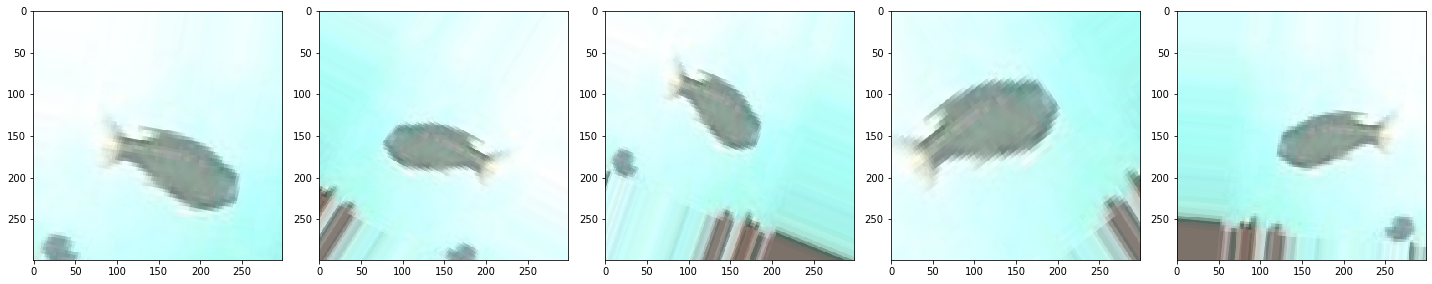

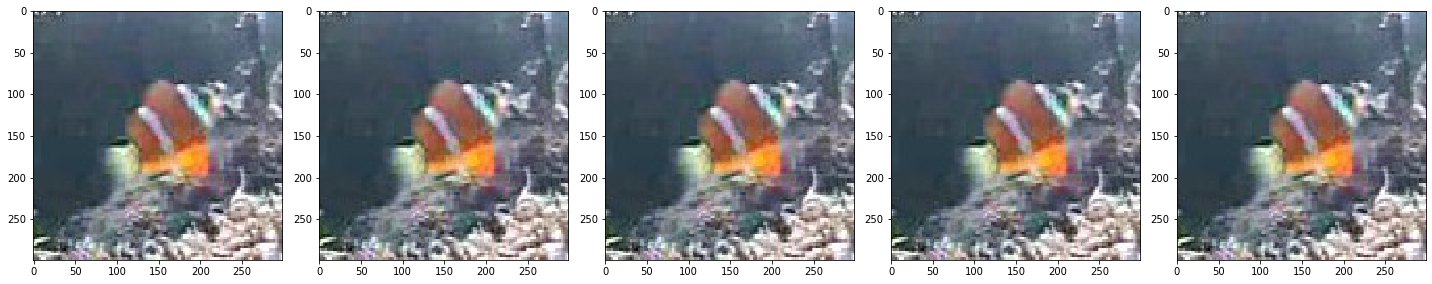

In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

augmented_images = [val_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [12]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))/255.0
  return image, label

In [13]:
URL = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [14]:
feature_extractor.trainable = False

In [15]:
model = Sequential(feature_extractor)
model.add(Dense(512, activation='relu'))
model.add(Dense(12))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1536)              54336736  
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
dense_1 (Dense)              (None, 12)                6156      
Total params: 55,129,836
Trainable params: 793,100
Non-trainable params: 54,336,736
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 100

history = model.fit(train_data_gen,
                    epochs=epochs,
                    validation_data=val_data_gen)

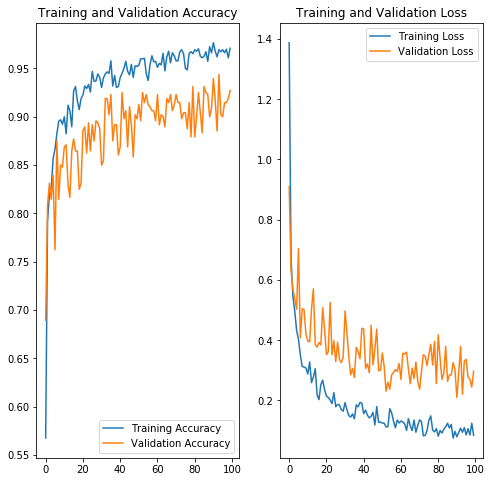

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
pAIrate_12_SAVED_MODEL = "exp_saved_model"

In [20]:
tf.saved_model.save(model, pAIrate_12_SAVED_MODEL)